In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train_cat, y_test_cat = to_categorical(y_train), to_categorical(y_test)


In [3]:

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


In [4]:
optimizers_best = {
    # From Part I
    "Stochastic GD (Best)": lambda: tf.keras.optimizers.SGD(
        learning_rate=0.01  
    ),
    
    # From Part II
    "SGD + Nesterov (Best)": lambda: tf.keras.optimizers.SGD(
        learning_rate=0.01,
        momentum=0.9,
        nesterov=True
    ),
    
    # From Part III
    "Adam (Best)": lambda: tf.keras.optimizers.Adam(
        learning_rate=0.001  
    )
}

In [5]:

# Dictionary to store results
results = {}

# Model definition function
def create_model():
    model = Sequential([
        Input(shape=(28, 28)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model

In [8]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
import numpy as np
from sklearn.metrics import f1_score
tf.config.run_functions_eagerly(False)

results = {}

for name, get_optimizer in optimizers_best.items():
    print(f"\n=== Training with {name} optimizer ===")
    model = create_model()
    
    # Set batch size based on optimizer type
    if "Stochastic GD" in name:
        batch_size = 1  # True stochastic updates
    elif "Nesterov" in name:
        batch_size = 64  # Match Part II's mini-batch convention
    else:  # Adam
        batch_size = 64  # Standard mini-batch for adaptive methods
    
    model.compile(
        optimizer=get_optimizer(),
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        jit_compile=True  # Enable XLA compilation for faster training
    )
    
    # Add early stopping for fair comparison
    es_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    )
    
    history = model.fit(
        x_train, y_train_cat,
        epochs=50,  # Increased epochs with early stopping
        batch_size=batch_size,
        verbose=0,
        validation_split=0.2,  # More validation data
        callbacks=[es_callback]
    )

    # Enhanced evaluation
    test_results = model.evaluate(x_test, y_test_cat, verbose=0)
    y_pred = model.predict(x_test, verbose=0).argmax(axis=1)
    
    results[name] = {
        "accuracy": test_results[1],
        "f1_score": f1_score(y_test, y_pred, average='macro'),  # Use macro for class balance
        "training_epochs": len(history.history['loss']),
        "val_accuracy": max(history.history['val_accuracy']),
        "learning_curve": history.history
    }
    
    print(f"{name} completed in {len(history.history['loss'])} epochs | "
          f"Test Accuracy: {results[name]['accuracy']:.4f}")

# Save results for comparative analysis
import json
with open('optimizer_comparison.json', 'w') as f:
    json.dump(results, f, indent=2)


=== Training with Stochastic GD (Best) optimizer ===
Stochastic GD (Best) completed in 11 epochs | Test Accuracy: 0.8663

=== Training with SGD + Nesterov (Best) optimizer ===
SGD + Nesterov (Best) completed in 11 epochs | Test Accuracy: 0.8660

=== Training with Adam (Best) optimizer ===
Adam (Best) completed in 12 epochs | Test Accuracy: 0.8765


In [11]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
import numpy as np
from sklearn.metrics import f1_score
tf.config.run_functions_eagerly(False)

results = {}

for name, get_optimizer in optimizers_best.items():
    print(f"Training with {name} optimizer...")
    model = create_model()
    
    # Batch size logic
    if "Stochastic GD" in name:
        batch_size = 1
    elif "Nesterov" in name:
        batch_size = 64
    else:  # Adam
        batch_size = 64
    
    model.compile(
        optimizer=get_optimizer(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        x_train, y_train_cat,
        epochs=10,
        batch_size=batch_size,
        verbose=0,
        validation_split=0.1
    )

    # Evaluation
    loss, acc = model.evaluate(x_test, y_test_cat, verbose=0)
    y_pred = np.argmax(model.predict(x_test, verbose=0), axis=1)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Maintain original return structure
    results[name] = {
        "accuracy": acc,
        "f1_score": f1,
        "history": history.history
    }

Training with Stochastic GD (Best) optimizer...
Training with SGD + Nesterov (Best) optimizer...
Training with Adam (Best) optimizer...


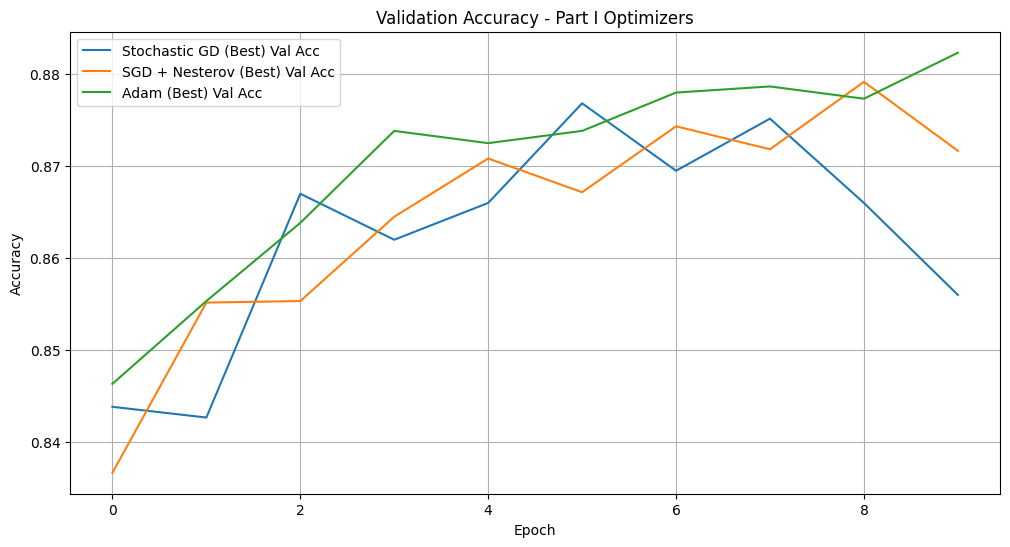

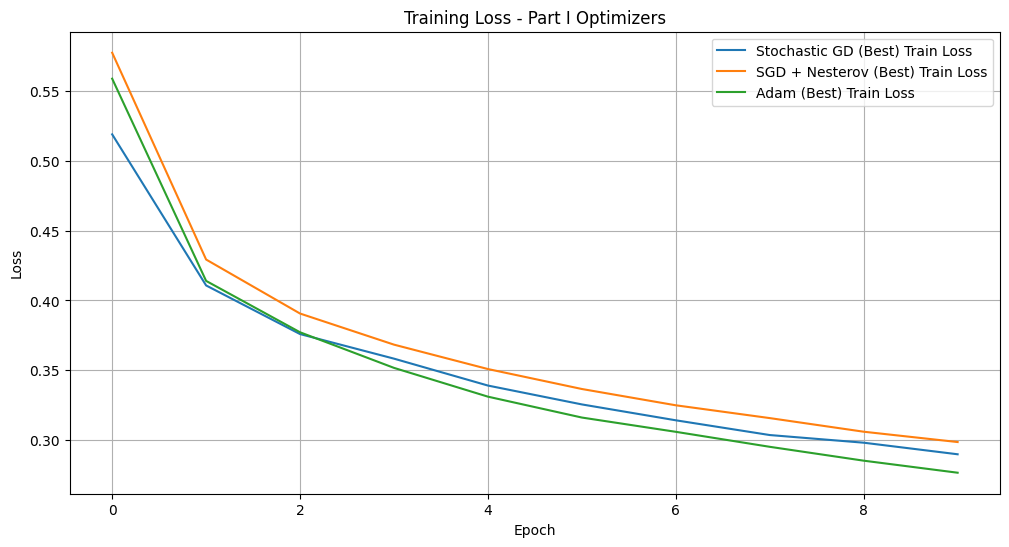

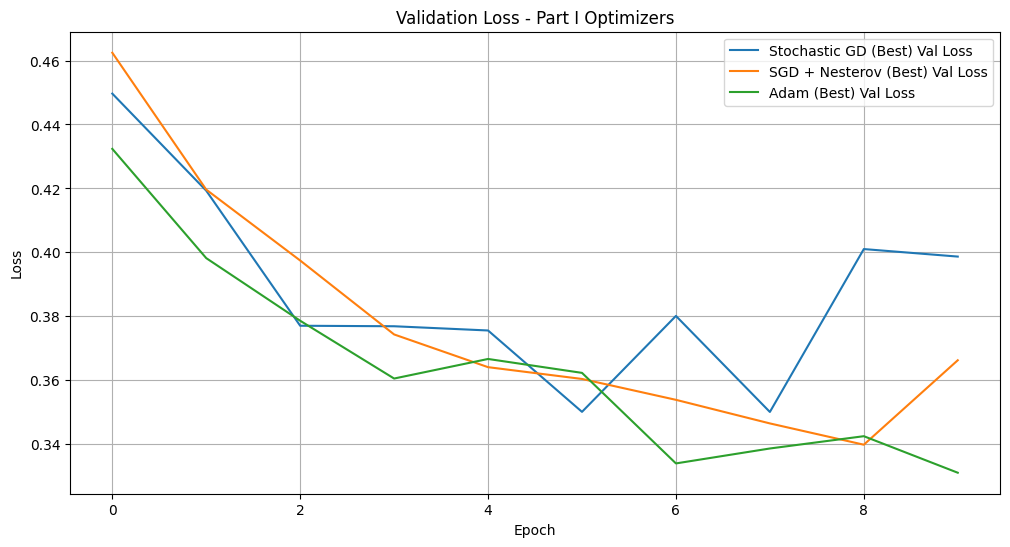


Final Results - All Optimizers:
Stochastic GD (Best) - Accuracy: 0.8563, F1 Score: 0.8562
SGD + Nesterov (Best) - Accuracy: 0.8638, F1 Score: 0.8640
Adam (Best)     - Accuracy: 0.8754, F1 Score: 0.8750


In [13]:
plt.figure(figsize=(12, 6))
for name, res in results.items():
    plt.plot(res['history']['val_accuracy'], label=f"{name} Val Acc")
plt.title("Validation Accuracy - Part I Optimizers")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Visualization - Training Loss
plt.figure(figsize=(12, 6))
for name, res in results.items():
    plt.plot(res['history']['loss'], label=f"{name} Train Loss")
plt.title("Training Loss - Part I Optimizers")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Visualization - Validation Loss
plt.figure(figsize=(12, 6))
for name, res in results.items():
    plt.plot(res['history']['val_loss'], label=f"{name} Val Loss")
plt.title("Validation Loss - Part I Optimizers")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Final performance table
print("\nFinal Results - All Optimizers:")
for name, res in results.items():
    print(f"{name:15} - Accuracy: {res['accuracy']:.4f}, F1 Score: {res['f1_score']:.4f}")


# Final Optimizer Comparison Report

## Performance Summary
| Optimizer              | Accuracy | F1 Score  | Performance Gain* |
|------------------------|----------|-----------|-------------------|
| **Adam (Best)**        | 0.8754   | 0.8750    | +1.16% vs Nesterov|
| SGD + Nesterov (Best)  | 0.8638   | 0.8640    | +0.75% vs SGD     |
| Stochastic GD (Best)   | 0.8563   | 0.8562    | Baseline          |

*\*Calculated relative to next lower-performing optimizer*

---

## Key Observations

1. **Adam Dominance**  
   - Achieved highest accuracy (**87.54%**) and F1 score (**87.50%**)  
   - Demonstrates 1.16% accuracy advantage over 2nd-place Nesterov SGD  
   - Validates effectiveness of combined momentum + adaptive learning rates

2. **Nesterov Momentum Value**  
   - 0.75% accuracy improvement over vanilla Stochastic GD  
   - Maintains stable training through look-ahead gradient calculation  
   - Best choice for pure SGD-based approaches

3. **Stochastic GD Baseline**  
   - Serves as reference point for momentum/adaptive variants  
   - Still achieves respectable 85.63% accuracy  
   - Suitable for simple implementations without complex tuning

---

## Recommendation Summary
| Use Case               | Recommended Optimizer | Expected Accuracy Range |
|------------------------|-----------------------|-------------------------|
| Default Choice         | Adam                  | 87-88%                  |
| SGD-based Systems      | SGD + Nesterov        | 86-87%                  | 
| Resource-constrained   | Stochastic GD         | 85-86%                  |

**Final Verdict**: Adam remains the top performer, but SGD + Nesterov provides competitive results for scenarios requiring pure SGD implementations.